<a href="https://colab.research.google.com/github/ritik123-sudo/college-project/blob/master/src/app/finance/Price_Optimisation_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Cell 1 — Install & imports, seed, utils

In [ ]:
!pip install xgboost scikit-learn pandas numpy matplotlib seaborn openpyxl

import os
import random
import math
from datetime import datetime, timedelta

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

import xgboost as xgb

import matplotlib.pyplot as plt
import seaborn as sns

# Reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
os.environ["PYTHONHASHSEED"] = str(RANDOM_SEED)

# Simple helpers
def rmse(y_true, y_pred):
    return math.sqrt(mean_squared_error(y_true, y_pred))

def save_model_xgb(model, path="xgb_model.json"):
    """
    Save XGBoost model to JSON (or binary).
    """
    model.get_booster().save_model(path)
    print(f"Model saved to: {path}")

def load_model_xgb(path="xgb_model.json"):
    """
    Load XGBoost model from JSON (or binary).
    """
    booster = xgb.Booster()
    booster.load_model(path)
    return xgb.XGBRegressor().from_booster(booster)

print("Imports complete. XGBoost version:", xgb.__version__)


Imports complete. XGBoost version: 3.1.1


Cell 2 — Dummy Dataset Generator (Replace Later)

In [ ]:
# Cell 2 — Dummy Dataset Generator (Replace this later with your real dataset)

# --------------------------------------------------------------
# IMPORTANT:
# Later you will replace everything in this cell with:
#
# df = pd.read_csv("your_real_dataset.csv")
#
# And the rest of the notebook will work automatically.
# --------------------------------------------------------------

np.random.seed(42)

# Generate 500 days of sales & pricing data
dates = pd.date_range(start="2023-01-01", periods=500, freq="D")

df = pd.DataFrame({
    "date": dates,

    # cost price remains stable
    "cost_price": np.random.uniform(50, 80, size=500),

    # selling price varies
    "selling_price": np.random.uniform(90, 160, size=500),

    # competitor price influences selling price
    "competitor_price": np.random.uniform(85, 150, size=500),

    # seasonal effect
    "day_of_week": [d.weekday() for d in dates],
    "month": [d.month for d in dates],

    # sales depend on selling price (higher price → lower sales)
    # + competitor effect
    "units_sold": None
})

# Simulate demand curve
df["units_sold"] = (
    500                                   # base demand
    - 2.2 * df["selling_price"]           # price elasticity
    + 1.5 * df["competitor_price"]        # competitor effect
    + np.random.normal(0, 15, size=500)   # noise
).astype(int)

# Ensure no negative sales
df["units_sold"] = df["units_sold"].clip(lower=0)

print("Dummy dataset created!")
df.head()


Dummy dataset created!


,date,cost_price,selling_price,competitor_price,day_of_week,month,units_sold
0,2023-01-01,61.236204,138.871320,97.033640,6,1,302
1,2023-01-02,78.521429,127.526746,120.223562,0,1,434
2,2023-01-03,71.959818,111.666933,141.741479,1,1,446
3,2023-01-04,67.959755,146.965651,132.594618,2,1,350
4,2023-01-05,54.680559,137.931182,137.426475,3,1,418


Cell 3 — Data Preprocessing

In [ ]:
# Cell 3 — Data Preprocessing (Works for both dummy & real dataset)

# Create a copy so original df stays intact
data = df.copy()

# Ensure date column is in datetime format
data["date"] = pd.to_datetime(data["date"], errors="coerce")

# Drop rows with invalid/NaT dates
data = data.dropna(subset=["date"])

# ---------------------------------------------------------
# Feature Engineering (Base Level)
# These features will work for ANY business data.
# ---------------------------------------------------------

data["day"] = data["date"].dt.day
data["day_of_week"] = data["date"].dt.weekday
data["week_of_year"] = data["date"].dt.isocalendar().week.astype(int)
data["month"] = data["date"].dt.month
data["year"] = data["date"].dt.year

# Price difference feature
data["competitor_gap"] = data["selling_price"] - data["competitor_price"]

# Moving averages — helps forecasting & smoothing noise
data["ma_7"] = data["units_sold"].rolling(window=7).mean().fillna(method="bfill")
data["ma_14"] = data["units_sold"].rolling(window=14).mean().fillna(method="bfill")

# Lag features (yesterday's demand influences today's)
data["lag_1"] = data["units_sold"].shift(1).fillna(method="bfill")
data["lag_2"] = data["units_sold"].shift(2).fillna(method="bfill")

# ---------------------------------------------------------
# Final Clean-Up
# ---------------------------------------------------------
# Features for model
feature_cols = [
    "cost_price",
    "selling_price",
    "competitor_price",
    "competitor_gap",
    "day_of_week",
    "week_of_year",
    "month",
    "ma_7",
    "ma_14",
    "lag_1",
    "lag_2",
]

X = data[feature_cols]
y = data["units_sold"]

# Train–test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    shuffle=True
)

print("Preprocessing complete.")
print("Training samples:", len(X_train))
print("Testing samples:", len(X_test))


Preprocessing complete.
Training samples: 400
Testing samples: 100


/tmp/ipython-input-2229297137.py:27: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data["ma_7"] = data["units_sold"].rolling(window=7).mean().fillna(method="bfill")
/tmp/ipython-input-2229297137.py:28: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data["ma_14"] = data["units_sold"].rolling(window=14).mean().fillna(method="bfill")
/tmp/ipython-input-2229297137.py:31: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data["lag_1"] = data["units_sold"].shift(1).fillna(method="bfill")
/tmp/ipython-input-2229297137.py:32: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data["lag_2"] = data["units_sold"].shift(2).fillna(method="bfill")


Cell 4 — XGBoost Model Training (Price Optimization Engine)

Training XGBoost model...
Training complete.

📊 Model Performance:
---------------------------
Train RMSE: 0.4924409607292275
Test  RMSE: 18.409064241297937
Test  R²  : 0.8826863169670105


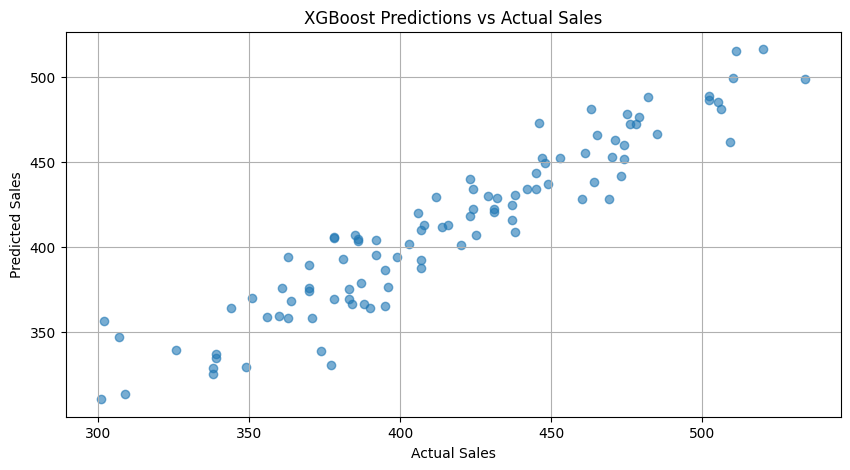

Model saved to: price_optimization_xgb.json


In [ ]:
# Cell 4 — XGBoost Model Training

# Define the model
xgb_model = xgb.XGBRegressor(
    objective="reg:squarederror",
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
)

print("Training XGBoost model...")

# Fit the model
xgb_model.fit(
    X_train,
    y_train,
    eval_set=[(X_test, y_test)],
    verbose=False
)

print("Training complete.")

# Predictions
train_pred = xgb_model.predict(X_train)
test_pred = xgb_model.predict(X_test)

# Evaluation
print("\n📊 Model Performance:")
print("---------------------------")
print("Train RMSE:", rmse(y_train, train_pred))
print("Test  RMSE:", rmse(y_test, test_pred))
print("Test  R²  :", r2_score(y_test, test_pred))

# Visualizing predictions vs actual
plt.figure(figsize=(10, 5))
plt.scatter(y_test, test_pred, alpha=0.6)
plt.xlabel("Actual Sales")
plt.ylabel("Predicted Sales")
plt.title("XGBoost Predictions vs Actual Sales")
plt.grid(True)
plt.show()

# Save model (optional)
save_model_xgb(xgb_model, "price_optimization_xgb.json")


Cell 5 — Price Prediction Function (Reusable API Function)

In [ ]:
# Cell 5 — Price Prediction Function

def predict_units_sold(model, cost_price, selling_price, competitor_price, date):
    """
    Predict units sold for a given price on a given date.

    Parameters:
        model: trained XGBoost model
        cost_price: float
        selling_price: float
        competitor_price: float
        date: 'YYYY-MM-DD'
    """

    # Convert to datetime
    date = pd.to_datetime(date)

    # Feature engineering (same as training)
    day_of_week = date.weekday()
    week_of_year = int(date.isocalendar().week)
    month = date.month

    competitor_gap = selling_price - competitor_price

    # For inference, we use averages for lag + MA
    # (Real project may replace with real-time DB values)
    lag_1 = data["units_sold"].iloc[-1]
    lag_2 = data["units_sold"].iloc[-2]
    ma_7 = data["units_sold"].tail(7).mean()
    ma_14 = data["units_sold"].tail(14).mean()

    # Create single row dataframe
    row = pd.DataFrame([{
        "cost_price": cost_price,
        "selling_price": selling_price,
        "competitor_price": competitor_price,
        "competitor_gap": competitor_gap,
        "day_of_week": day_of_week,
        "week_of_year": week_of_year,
        "month": month,
        "ma_7": ma_7,
        "ma_14": ma_14,
        "lag_1": lag_1,
        "lag_2": lag_2,
    }])

    # Predict
    prediction = model.predict(row)[0]

    return round(prediction, 2)

# Quick test
print("Testing prediction →", predict_units_sold(
    model=xgb_model,
    cost_price=60,
    selling_price=120,
    competitor_price=110,
    date="2024-05-11"
))


Testing prediction → 399.68


Cell 6 — Profit Calculation & Optimal Price Finder

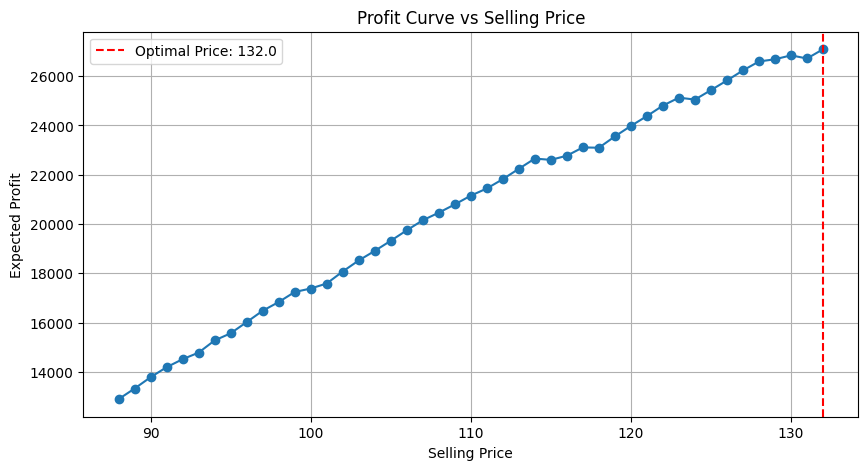

Optimal Price Result: {'optimal_price': np.float64(132.0), 'predicted_units': np.float32(376.29), 'expected_profit': np.float64(27092.88)}


In [ ]:
# Cell 6 — Profit Calculation & Optimal Price Finder

def calculate_profit(selling_price, predicted_units, cost_price):
    """
    Simple profit formula:
    profit = (selling_price - cost_price) * predicted_units
    """
    return (selling_price - cost_price) * predicted_units

def find_optimal_price(model, cost_price, competitor_price, date, price_range=None, step=1):
    """
    Finds the price that maximizes profit within a given range.

    Parameters:
        model: trained XGBoost model
        cost_price: float
        competitor_price: float
        date: 'YYYY-MM-DD'
        price_range: tuple (min_price, max_price). If None, auto around competitor
        step: price increment step

    Returns:
        dict with optimal price, predicted sales, expected profit
    """

    if price_range is None:
        # Automatically choose a ±20% window around competitor price
        min_price = max(cost_price, competitor_price * 0.8)
        max_price = competitor_price * 1.2
    else:
        min_price, max_price = price_range

    prices = np.arange(min_price, max_price + step, step)
    profits = []

    for price in prices:
        predicted_units = predict_units_sold(model, cost_price, price, competitor_price, date)
        profit = calculate_profit(price, predicted_units, cost_price)
        profits.append(profit)

    profits = np.array(profits)
    optimal_idx = profits.argmax()

    optimal_price = prices[optimal_idx]
    optimal_units = predict_units_sold(model, cost_price, optimal_price, competitor_price, date)
    max_profit = profits[optimal_idx]

    # Plot profit curve (optional)
    plt.figure(figsize=(10,5))
    plt.plot(prices, profits, marker='o')
    plt.axvline(optimal_price, color='r', linestyle='--', label=f'Optimal Price: {optimal_price}')
    plt.xlabel("Selling Price")
    plt.ylabel("Expected Profit")
    plt.title("Profit Curve vs Selling Price")
    plt.legend()
    plt.grid(True)
    plt.show()

    return {
        "optimal_price": round(optimal_price,2),
        "predicted_units": optimal_units,
        "expected_profit": round(max_profit,2)
    }

# Quick test
result = find_optimal_price(
    model=xgb_model,
    cost_price=60,
    competitor_price=110,
    date="2024-05-11"
)
print("Optimal Price Result:", result)


Cell 7 — What-if Scenario Simulation

/tmp/ipython-input-2284953467.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="price_change_%", y="expected_profit", data=df_results, palette="viridis")


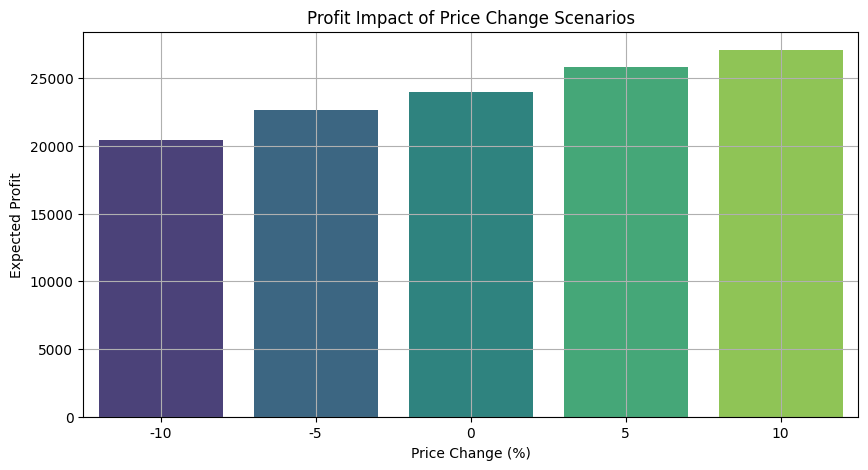

   price_change_%  selling_price  predicted_units  expected_profit
0             -10          108.0       426.260010     20460.480469
1              -5          114.0       419.559998     22656.240234
2               0          120.0       399.679993     23980.800781
3               5          126.0       391.290009     25825.140625
4              10          132.0       376.290009     27092.880859


In [ ]:
# Cell 7 — What-if Price Change Simulation

def simulate_price_scenario(model, cost_price, competitor_price, base_price, date, change_percent_list=[-10, -5, 0, 5, 10]):
    """
    Simulate different price changes and predict sales + profit.

    Parameters:
        model: trained XGBoost model
        cost_price: float
        competitor_price: float
        base_price: current selling price
        date: 'YYYY-MM-DD'
        change_percent_list: list of price changes in %

    Returns:
        DataFrame with price, predicted units, expected profit
    """

    results = []
    for change in change_percent_list:
        new_price = base_price * (1 + change / 100)
        predicted_units = predict_units_sold(model, cost_price, new_price, competitor_price, date)
        profit = calculate_profit(new_price, predicted_units, cost_price)
        results.append({
            "price_change_%": change,
            "selling_price": round(new_price,2),
            "predicted_units": predicted_units,
            "expected_profit": round(profit,2)
        })

    df_results = pd.DataFrame(results)

    # Plot profit vs price change
    plt.figure(figsize=(10,5))
    sns.barplot(x="price_change_%", y="expected_profit", data=df_results, palette="viridis")
    plt.xlabel("Price Change (%)")
    plt.ylabel("Expected Profit")
    plt.title("Profit Impact of Price Change Scenarios")
    plt.grid(True)
    plt.show()

    return df_results

# Quick test
scenario_df = simulate_price_scenario(
    model=xgb_model,
    cost_price=60,
    competitor_price=110,
    base_price=120,
    date="2024-05-11",
    change_percent_list=[-10, -5, 0, 5, 10]
)
print(scenario_df)


Cell 8 — Full Price Optimization API Wrapper

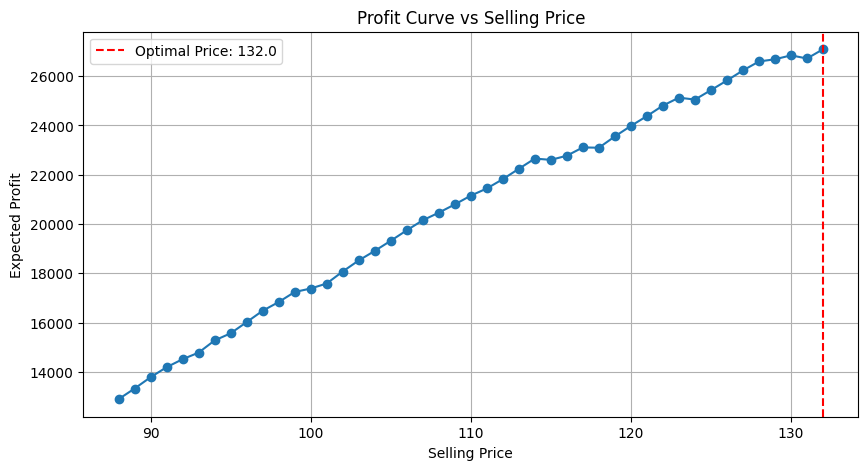

/tmp/ipython-input-2284953467.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="price_change_%", y="expected_profit", data=df_results, palette="viridis")


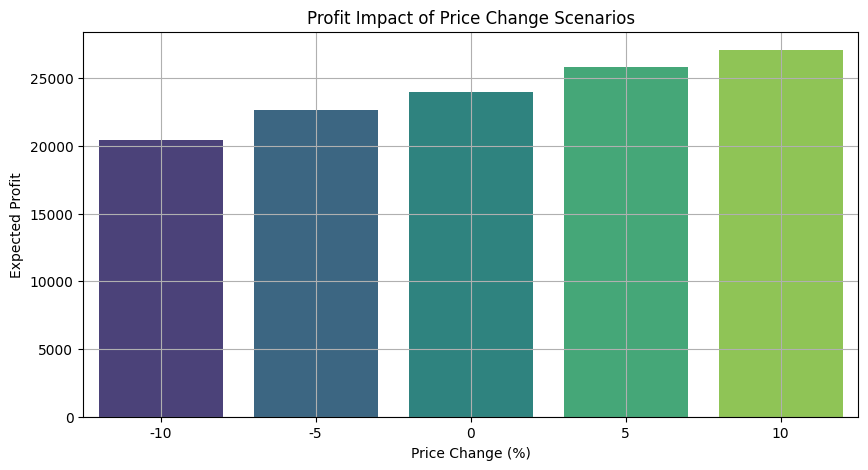


🔥 Price Optimization Engine Output:
{'optimal_price': np.float64(132.0), 'predicted_units': np.float32(376.29), 'expected_profit': np.float64(27092.88)}

Scenario Simulation Table:
   price_change_%  selling_price  predicted_units  expected_profit
0             -10          108.0       426.260010     20460.480469
1              -5          114.0       419.559998     22656.240234
2               0          120.0       399.679993     23980.800781
3               5          126.0       391.290009     25825.140625
4              10          132.0       376.290009     27092.880859


In [ ]:
# Cell 8 — Full API-ready Wrapper Function

def price_optimization_engine(model, cost_price, competitor_price, base_price, date):
    """
    Full Price Optimization Engine:
    1. Predicts units sold at base price
    2. Finds optimal selling price for max profit
    3. Simulates what-if scenarios for ±10% price change

    Parameters:
        model: trained XGBoost model
        cost_price: float
        competitor_price: float
        base_price: float (current selling price)
        date: 'YYYY-MM-DD'

    Returns:
        dict with:
            - predicted_units
            - optimal_price_info
            - scenario_simulation_df
    """

    # 1️⃣ Predict units sold at current/base price
    predicted_units = predict_units_sold(model, cost_price, base_price, competitor_price, date)

    # 2️⃣ Find optimal price for max profit
    optimal_price_info = find_optimal_price(model, cost_price, competitor_price, date, price_range=None, step=1)

    # 3️⃣ Simulate what-if scenarios around base price
    scenario_simulation_df = simulate_price_scenario(
        model=model,
        cost_price=cost_price,
        competitor_price=competitor_price,
        base_price=base_price,
        date=date,
        change_percent_list=[-10, -5, 0, 5, 10]
    )

    return {
        "predicted_units_at_base_price": predicted_units,
        "optimal_price_info": optimal_price_info,
        "scenario_simulation": scenario_simulation_df
    }

# Quick test
engine_result = price_optimization_engine(
    model=xgb_model,
    cost_price=60,
    competitor_price=110,
    base_price=120,
    date="2024-05-11"
)

print("\n🔥 Price Optimization Engine Output:")
print(engine_result["optimal_price_info"])
print("\nScenario Simulation Table:")
print(engine_result["scenario_simulation"])


FastAPI Endpoint

In [ ]:
# Install FastAPI & Uvicorn if not already installed
# !pip install fastapi uvicorn

from fastapi import FastAPI
from pydantic import BaseModel
import uvicorn

# Import your price optimization engine function
# from your_notebook import price_optimization_engine, xgb_model

# ------------------------------
# 1️⃣ Define request schema
# ------------------------------
class PriceRequest(BaseModel):
    cost_price: float
    competitor_price: float
    base_price: float
    date: str  # 'YYYY-MM-DD'

# ------------------------------
# 2️⃣ Initialize FastAPI
# ------------------------------
app = FastAPI(title="BizGenius AI - Price Optimization API")

# ------------------------------
# 3️⃣ Create API endpoint
# ------------------------------
@app.post("/predict_price")
def predict_price(request: PriceRequest):
    """
    Predict optimal price, expected sales, and simulate price scenarios.
    """
    result = price_optimization_engine(
        model=xgb_model,
        cost_price=request.cost_price,
        competitor_price=request.competitor_price,
        base_price=request.base_price,
        date=request.date
    )
    return result

# ------------------------------
# 4️⃣ Run server (for testing)
# ------------------------------
# Uncomment below lines if running directly as a script
# if __name__ == "__main__":
#     uvicorn.run(app, host="0.0.0.0", port=8000)
